In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

import os
import pickle

import time

In [2]:
import PyNAFF as pnf

from tune_diagram import ResonanceLines

In [3]:
from scipy.constants import e, m_p, c, epsilon_0
from scipy.constants import physical_constants

In [4]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

In [5]:
import pysixtrack.be_beamfields.tools as bt

In [6]:
import sys
sys.path.append('/home/oeftiger/gsi/git/python3/PyHEADTAIL/')
from PyHEADTAIL.particles import generators
from PyHEADTAIL.trackers.rf_bucket import RFBucket

PyHEADTAIL v1.13.5




/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


# VERSIONING

## SixTrackLib:

In [7]:
f = os.path.dirname(pyst.__file__)
f

'/home/oeftiger/gsi/git/sixtracklib_aoeftiger/python/sixtracklib'

In [8]:
!cd $f && git log | head -4

commit deff9373703a3b27bd238562f6db3502b0c16820
Author: Adrian Oeftiger <a.oeftiger@gsi.de>
Date:   Wed Jan 8 14:03:25 2020 +0100



## PySixTrack:

In [9]:
f = os.path.dirname(pysixtrack.__file__)
f

'/home/oeftiger/gsi/git/pysixtrack_hannes/pysixtrack'

In [10]:
!cd $f && git log | head -4

commit 4ce2927b4bd5df52670b3f08b12231a12c8fd53b
Author: Hannes Bartosik <hannes.bartosik@cern.ch>
Date:   Wed Jan 8 08:24:11 2020 +0100



# Parameters

In [11]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
# nmass = 0.931494061 # MAD-X value

In [12]:
tune_range_qx = np.arange(18.55, 18.95 + 0.01, 0.01)
tune_range_qy = tune_range_qx

In [13]:
nturns = 128 #20000 #2**16
npart = 1000

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

# sc_mode = 'Coasting'
sc_mode = 'Bunched'
intensity = 0.625e11
n_scnodes = 500

###

mass_eV = A * nmass * 1e9
mass = mass_eV * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [14]:
epsx_rms_fin = 35e-6 / 4 # geometrical emittances
epsy_rms_fin = 15e-6 / 4

limit_n_rms_x = 3.4#2
limit_n_rms_y = 3.4#2
limit_n_rms_z = 2.5#3.4

sig_z = 58 / 4. # in m
sig_dp = 0.5e-3

V_rf = 58.2e3

###

epsx_gauss = epsx_rms_fin #* 1.778 RMS adjustment not needed if limit_n_rms are >>2!
epsy_gauss = epsy_rms_fin #* 1.82 RMS adjustment not needed if limit_n_rms are >>2!

epsn_x = epsx_gauss * beta * gamma
epsn_y = epsy_gauss * beta * gamma

beta_z = sig_z / sig_dp

# 1. no errors, no aperture $Q_x=.95, Q_y=.94$

In [15]:
# e_seed = 1

qx = 18.95#84 #tune_range_qx[0]
qy = 18.94#73 #tune_range_qy[0]
install_apertures = False
apply_errors = False

pystl_device = "opencl:0.0"

qqx, qqy = int(np.round((qx%1) * 100)), int(np.round((qy%1) * 100))

# filename_error_table = "./error_tables/errors_{qqx}_{qqy}_{eseed:d}".format(
#             qqx=qqx, qqy=qqy, eseed=e_seed)

madx = Madx()
madx.options.echo = False
madx.options.warn = False

madx.call('./SIS100_RF_220618_9slices.thin.seq')

madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot) # /Q for RF to have proton beam!

madx.call('OpticsYEH_BeamParameters.str')
madx.call('Coll+Errors+BeamDistr.madx')

madx.use(sequence='sis100ring')

### --> first match, then add errors, then TWISS!

madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=qx, qy=qy)
)

if apply_errors:
    madx.command.eoption(add=True, seed=1)
    madx.command.exec('EA_EFCOMP_MH()')
    for s in range(1, 10):
        assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

twiss = madx.twiss();

if apply_errors:
    madx.command.select(flag='error', pattern='QD11..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='QD12..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh1', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh2', class_='MULTIPOLE')
    madx.command.esave(file=filename_error_table)

if apply_errors:
    madx.command.readtable(file=filename_error_table, table="errors")
    errors = madx.table.errors

sis100 = madx.sequence.sis100ring


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.01.08 14:33:21      +
  ++++++++++++++++++++++++++++++++++++++++++++
START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   7.17860577e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.82687e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.82132e-01 -2.80616e-01 -1.00000e+20  1.

In [16]:
pysixtrack_elements_temp = pysixtrack.Line.from_madx_sequence(sis100)

In [17]:
l_target = twiss.summary.length / n_scnodes
l_fuzz = l_target / 2.

sc_locations, sc_lengths = bt.determine_sc_locations(
    pysixtrack_elements_temp, n_scnodes, l_fuzz
)

In [18]:
sc_names = ["sc%d" % number for number in range(len(sc_locations))]

In [19]:
bt.install_sc_placeholders(madx, 'SIS100RING', sc_names, sc_locations, mode=sc_mode)

In [20]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    sis100, exact_drift=True, install_apertures=install_apertures
)

pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [21]:
mad_sc_names, sc_twdata = bt.get_spacecharge_names_twdata(
    madx, "SIS100RING", mode=sc_mode
)

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       1083.599999                 -0     0.003995487772        15.82031393 

                q1                dq1            betxmax              dxmax 
             18.95       -40.27445664        20.63345413        3.045215294 

             dxrms             xcomax             xcorms                 q2 
       1.349146091                  0                  0        18.93999912 

               dq2            betymax              dymax              dyrms 
      -41.05324599        24.32804209                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [22]:
# Check consistency
if sc_mode == "Bunched":
    sc_elements, sc_names = pysixtrack_elements.get_elements_of_type(
        pysixtrack.elements.SpaceChargeBunched
    )
elif sc_mode == "Coasting":
    sc_elements, sc_names = pysixtrack_elements.get_elements_of_type(
        pysixtrack.elements.SpaceChargeCoasting
    )
else:
    raise ValueError("mode not understood")

In [23]:
bt.check_spacecharge_consistency(
    sc_elements, sc_names, sc_lengths, mad_sc_names
)

In [25]:
# Setup spacecharge in the line
if sc_mode == "Bunched":
    bt.setup_spacecharge_bunched_in_line(
        sc_elements,
        sc_lengths,
        sc_twdata,
        beta * gamma,
        intensity,
        sig_z,
        sig_dp,
        epsn_x,
        epsn_y,
    )
elif sc_mode == "Coasting":
    raise NotImplementedError(
        'have to supply line_density')
    bt.setup_spacecharge_coasting_in_line(
        sc_elements,
        sc_lengths,
        sc_twdata,
        beta * gamma,
        line_density,
        sig_dp,
        epsn_x,
        epsn_y,
    )

In [26]:
cavities = [f for f in pysixtrack_elements.elements if 'avity' in str(f)]
for f in cavities:
    f.voltage = V_rf / float(len(cavities))

In [27]:
# voltages of all SIS100 cavities:
sum([f.voltage for f in pysixtrack_elements.elements if 'avity' in str(f)])

58199.99999999998

In [28]:
# madx.input('cavity_voltage = 58.2/1000/number_cavities;')

In [29]:
# particle initialisation from pyheadtail

x_co = twiss['x'][0]
y_co = twiss['y'][0]
D_x_0 = twiss['dx'][0] * beta
D_y_0 = twiss['dy'][0] * beta
Dp_x_0 = twiss['dpx'][0] * beta
Dp_y_0 = twiss['dpy'][0] * beta

np.random.seed(0)

pyht_beam = generators.generate_Gaussian6DTwiss(
    npart, 1, charge, mass, twiss['s'][-1], gamma,
    twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
    1, epsn_x, epsn_y, 1,
    dispersion_x=None, #D_x_0 if D_x_0 else None,
    dispersion_y=None, #D_y_0 if D_y_0 else None,
    limit_n_rms_x=limit_n_rms_x**2, limit_n_rms_y=limit_n_rms_y**2, 
    limit_n_rms_z=limit_n_rms_z**2,
)

distribution_z_uncut = generators.gaussian2D(
    sig_z**2)
is_accepted = generators.make_is_accepted_within_n_sigma(
    epsn_rms=sig_z,
    limit_n_rms=limit_n_rms_z,
)
distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

z, dp = distribution_z_cut(npart)
pyht_beam.z, pyht_beam.dp = z, dp / beta_z

# PyHT generates around 0, need to offset with closed orbit:
pyht_beam.x += x_co
pyht_beam.y += y_co
# add dispersive contribution to coordinates:
pyht_beam.x += D_x_0 * pyht_beam.dp
pyht_beam.y += D_y_0 * pyht_beam.dp
# also need to add D'_{x,y} to momenta:
pyht_beam.xp += Dp_x_0 * pyht_beam.dp
pyht_beam.yp += Dp_y_0 * pyht_beam.dp

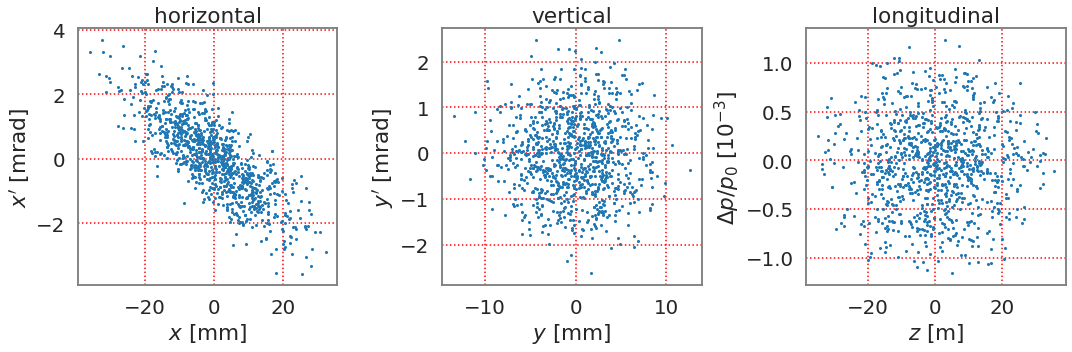

In [30]:
plot_every = 1

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal')
plt.scatter(pyht_beam.x[::plot_every] * 1e3, pyht_beam.xp[::plot_every] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.x.min() * 1e3, 1.1*pyht_beam.x.max() * 1e3)
plt.ylim(1.1*pyht_beam.xp.min() * 1e3, 1.1*pyht_beam.xp.max() * 1e3)
plt.xlabel('$x$ [mm]')
plt.ylabel("$x'$ [mrad]")

# plt.axvline(pyht_beam.sigma_x(), color='red')
# plt.axvline(2*pyht_beam.sigma_x(), color='red')
# plt.axvline(3*pyht_beam.sigma_x(), color='red')
# plt.axvline(3.4*pyht_beam.sigma_x(), color='red')

# ep = mpl.patches.Ellipse(
#     (0, 0), 2*pyht_beam.sigma_x() * 1e3, 2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 2*2*pyht_beam.sigma_x() * 1e3, 2*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3*2*pyht_beam.sigma_x() * 1e3, 3*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='--')
# plt.gca().add_patch(ep)
# ep = mpl.patches.Ellipse(
#     (0, 0), 3.4*2*pyht_beam.sigma_x() * 1e3, 3.4*2*pyht_beam.sigma_xp() * 1e3,
#     lw=2, fill=False, color='red', zorder=20, ls='solid')
# plt.gca().add_patch(ep)

plt.sca(ax[1])
plt.title('vertical')
plt.scatter(pyht_beam.y[::plot_every] * 1e3, pyht_beam.yp[::plot_every] * 1e3, s=10, marker='.')
plt.xlim(1.1*pyht_beam.y.min() * 1e3, 1.1*pyht_beam.y.max() * 1e3)
plt.ylim(1.1*pyht_beam.yp.min() * 1e3, 1.1*pyht_beam.yp.max() * 1e3)
plt.xlabel('$y$ [mm]')
plt.ylabel("$y'$ [mrad]")

plt.sca(ax[2])
plt.title('longitudinal')
plt.scatter(pyht_beam.z[::plot_every], pyht_beam.dp[::plot_every] * 1e3, s=10, marker='.')
plt.xlabel('$z$ [m]')
plt.ylabel(r"$\Delta p/p_0$ [$10^{-3}$]")
plt.tight_layout()

plt.savefig('particle_generation_phasespaces.png', dpi=150, bbox_inches='tight')

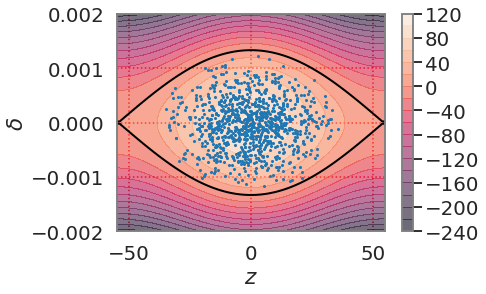

In [31]:
rfb = RFBucket(twiss.summary.length, gamma, mass, charge, [twiss.summary['gammatr']**-2], 
               0, [10], [V_rf], [np.pi])

z = np.linspace(*rfb.interval, num=100)
dp = np.linspace(-0.002, 0.002, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = rfb.hamiltonian(ZZ, DPP, make_convex=True)
plt.contourf(ZZ, DPP, HH, 20, alpha=0.6)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='black', linewidths=2)
plt.scatter(pyht_beam.z[::plot_every], pyht_beam.dp[::plot_every], s=10, marker='.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\delta$');

In [32]:
# add alignment and multipole errors

if apply_errors:
    pysixtrack_elements.apply_madx_errors(error_table=errors)

### Load lattice into SixTrackLib

elements = pyst.Elements.from_line(pysixtrack_elements)
elements.BeamMonitor(num_stores=nturns);

### Transfer particles into SixTrackLib
particles = pyst.Particles.from_ref(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

particles.x[:] = pyht_beam.x
particles.px[:] = pyht_beam.xp
particles.y[:] = pyht_beam.y
particles.py[:] = pyht_beam.yp
particles.zeta[:] = pyht_beam.z
particles.delta[:] = pyht_beam.dp

particles.rpp[:] = 1. / (pyht_beam.dp + 1)

restmass = mass * c**2
restmass_sq = restmass**2
E0 = np.sqrt((p0 * c)**2 + restmass_sq)
p = p0 * (1 + pyht_beam.dp)
E = np.sqrt((p * c)**2 + restmass_sq)
particles.psigma[:] = (E - E0) / (beta * p0 * c)

gammai = E / restmass
betai = np.sqrt(1 - 1. / (gammai * gammai))
particles.rvv[:] = betai / beta

### prepare trackjob in SixTrackLib

# trackjob = pyst.TrackJob(elements, particles)
trackjob = pyst.TrackJob(elements, particles, device=pystl_device)

print ('\n\n\n' + '+'*26 + '\n*** ready for tracking ***\n' + '+'*26 + '\n')




++++++++++++++++++++++++++
*** ready for tracking ***
++++++++++++++++++++++++++



In [33]:
t0 = time.time()

trackjob.track_until(nturns)
trackjob.collect()

# store = {}
# filename_error_table = os.path.basename(filename_error_table)

# # statistics
# x = trackjob.output.particles[0].x.reshape((nturns, npart)).T
# store['std_x'] = np.mean(np.std(x, axis=0)[-50:])
# y = trackjob.output.particles[0].y.reshape((nturns, npart)).T
# store['std_y'] = np.mean(np.std(y, axis=0)[-50:])

# # losses
# pbuffer = trackjob.particles_buffer.get_object(0)
# np.save('results/' + filename_error_table + '_alive.npy', pbuffer.state)
# np.save('results/' + filename_error_table + '_lost_at_element.npy', 
#         pbuffer.at_element[~pbuffer.state.astype(bool)])
# np.save('results/' + filename_error_table + '_lost_at_turn.npy',
#         pbuffer.at_turn[~pbuffer.state.astype(bool)])

# store['losses'] = np.sum(pbuffer.state)

# # finish job
# pickle.dump(store, open('results/' + filename_error_table + '_summary.p', 'wb'))

# !touch "results/$filename_error_table"_done

# del trackjob, elements, particles

t1 = time.time()

In [34]:
(t1 - t0) / 60.

0.1884192148844401

In [35]:
pbuffer = trackjob.particles_buffer.get_object(0)

In [36]:
np.sum(pbuffer.state)

1000

In [37]:
x = trackjob.output.particles[0].x
px = trackjob.output.particles[0].px
y = trackjob.output.particles[0].y
py = trackjob.output.particles[0].py
zeta = trackjob.output.particles[0].zeta
delta = trackjob.output.particles[0].delta

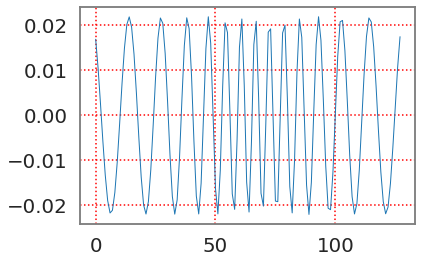

In [38]:
plt.plot(x[0::npart], lw=1)
# plt.xlim(10000, 10100)

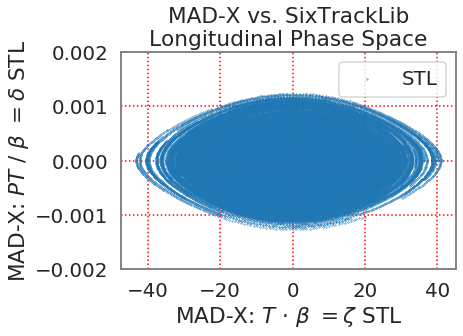

In [39]:
plt.scatter(zeta, 
            delta,
            marker='.', s=1, label='STL')
plt.legend()
plt.ylim(-2e-3, 2e-3);
plt.xlabel(r'MAD-X: $T$ $\cdot$ $\beta$ $=\zeta$ STL')
plt.ylabel(r'MAD-X: $PT$ $/$ $\beta$ $=\delta$ STL');
plt.title('MAD-X vs. SixTrackLib\nLongitudinal Phase Space');

# Tune shifts

In [40]:
print ('Space charge induced (Gaussian!) tune spread:')

D_x_avg = sum(np.array(sc_twdata['dispersion_x']) * np.array(sc_lengths)) / twiss.summary.length
D_y_avg = sum(np.array(sc_twdata['dispersion_y']) * np.array(sc_lengths)) / twiss.summary.length

lmbda = intensity * charge / (np.sqrt(2*np.pi) * sig_z)
Ksc = charge / (gamma**3 * mass * (beta * c)**2) * lmbda / (2*np.pi*epsilon_0)
R = twiss.summary.length / (2*np.pi)

sig_x = np.sqrt(epsn_x / (beta * gamma) * R / qx + D_x_avg**2 * sig_dp**2)
sig_y = np.sqrt(epsn_y / (beta * gamma) * R / qy + D_y_avg**2 * sig_dp**2)

def dQ_inc(thissize, theothersize, thistune, Ksc=Ksc):
    'incoherent KV tune shift'
    return Ksc * R**2 / (4 * thistune * thissize * (thissize+theothersize))

dQ_sc_x = 2 * dQ_inc(sig_x, sig_y, qx)
dQ_sc_y = 2 * dQ_inc(sig_y, sig_x, qy)

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_sc_x, dQ_sc_y))

Space charge induced (Gaussian!) tune spread:
dQ_x = 0.180 and dQ_y = 0.276


In [41]:
print ('Chromaticity induced RMS tune shift:')

dQ_chroma_x = twiss.summary.dq1 * beta * sig_dp
dQ_chroma_y = twiss.summary.dq2 * beta * sig_dp

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    dQ_chroma_x, dQ_chroma_y))

Chromaticity induced RMS tune shift:
dQ_x = -0.011 and dQ_y = -0.012


In [42]:
print ('SC + Chroma tune shift:')

print ('dQ_x = {0:.3f} and dQ_y = {1:.3f}'.format(
    np.abs(dQ_sc_x) + np.abs(dQ_chroma_x), 
    np.abs(dQ_sc_y) + np.abs(dQ_chroma_y)))

SC + Chroma tune shift:
dQ_x = 0.192 and dQ_y = 0.287


In [43]:
def get_tune(signal, turns=nturns):
    try:
        return pnf.naff(signal, turns, 1, 0 , False, window=1)[0, 1]
    except IndexError:
        return np.nan

In [44]:
qx_i = np.apply_along_axis(get_tune, 1, x.reshape((nturns, npart)).T)
qy_i = np.apply_along_axis(get_tune, 1, y.reshape((nturns, npart)).T)

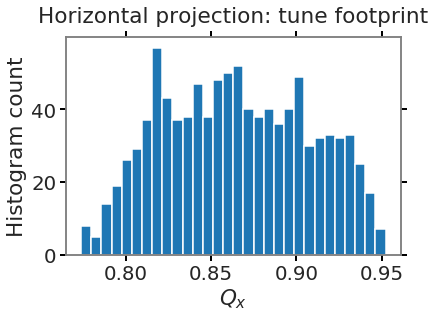

In [45]:
n, bins, _ = plt.hist(1 - qx_i, bins=30, label='128 first turns')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Horizontal projection: tune footprint', y=1.04)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('horizontalspectrum.png', dpi=150, bbox_inches='tight')

In [46]:
print ('max. dQ_x from tune footprint: {:.3f}'.format(bins[-1] - bins[0]))

max. dQ_x from tune footprint: 0.178


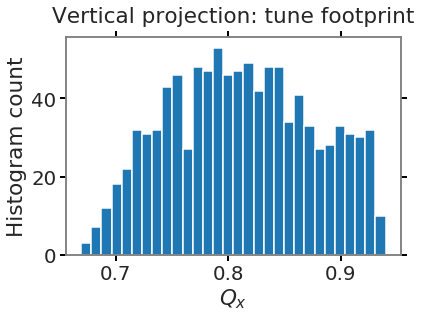

In [47]:
n, bins, _ = plt.hist(1 - qy_i, bins=30, label='128 first turns')
plt.xlabel("$Q_x$")
plt.ylabel('Histogram count')
plt.title('Vertical projection: tune footprint', y=1.04)
plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True, grid_linestyle='None')
plt.savefig('verticalspectrum.png', dpi=150, bbox_inches='tight')

In [48]:
print ('max. dQ_y from tune footprint: {:.3f}'.format(bins[-1] - bins[0]))

max. dQ_y from tune footprint: 0.271


In [49]:
Qx = qx
Qy = qy

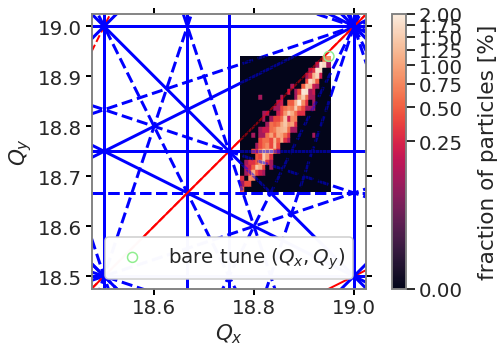

In [50]:
fig = plt.figure(figsize=(8,5)) 

extent_x = (np.floor(Qx) + 0.475, np.ceil(Qx) + 0.025)
extent_y = (np.floor(Qy) + 0.475, np.ceil(Qy) + 0.025)

resonances = ResonanceLines(extent_x, 
                            extent_y,
                            range(1, 4+1), 6) #1
resonances.plot_resonance(fig)
plt.gca().set_aspect('equal')

inc_tunes_x = np.floor(Qx) + 1 - np.abs(qx_i)[~np.isnan(qx_i)&~np.isnan(qy_i)]
inc_tunes_y = np.floor(Qy) + 1 - np.abs(qy_i)[~np.isnan(qy_i)&~np.isnan(qx_i)]

plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25,
           zorder=3, alpha=0.5, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
plt.hist2d(inc_tunes_x, inc_tunes_y, bins=25, 
           weights=np.ones_like(inc_tunes_x)/len(inc_tunes_x)*100,
           norm=mcolors.PowerNorm(0.3))
cbar = plt.colorbar()
cbar.set_label('fraction of particles [%]', labelpad=15)

plt.xlim(extent_x)
plt.ylim(extent_y)

plt.scatter(Qx, Qy, color='lightgreen', marker='o', facecolor='None', 
            linestyle='None', s=100, zorder=13, label=r"bare tune $(Q_x,Q_y)$")
plt.legend(loc=8, framealpha=0.98)

plt.gca().tick_params(direction='out', length=6, width=2, color='black', reset=True)
plt.grid(False)

plt.tight_layout()
plt.savefig('tunespread.png', dpi=150, bbox_inches='tight')